# DLVC WS 2017

Tutorial 5: MNIST Digits Classification (Autoencoders)
==

Load Packages
==

In [1]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import copy

Load Data:
===============

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 100

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

In [3]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

Define the Autoencoder:
===============

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 256),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(256, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
        
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=256)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=400)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784)
    (3): ReLU()
  )
)


Train Autoencoder:
===========

In [5]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
iterations = 20
learning_rate = 0.9
criterion = nn.MSELoss()

dataiter = iter(testloader)
images, labels = dataiter.next()
printImg = torch.Tensor(iterations/10,2,1,28,28)

for epoch in range(iterations):  # loop over the dataset multiple times
    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.view(-1, 28*28).double()).cuda()
        else:
            inputs = Variable(inputs.view(-1, 28*28).double())

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, inputs) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.data[0]
        
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
    if epoch%10 == 0:
        if use_gpu:
            outImg = net(Variable((images[0].view(-1,28*28).double().cuda()))).data
            outImg = outImg.view(-1,28,28).cpu()
        else:
            outImg = net(Variable((images[0].view(-1,28*28).double()))).data
            outImg = outImg.view(-1,28,28).cpu()

        dispImg = torch.Tensor(2,1,28,28)
        dispImg[0] = images[0]
        dispImg[1] = outImg
        printImg[epoch/10] = dispImg
print('Finished Training')

At Iteration : 1 / 20  ;  Mean-Squared Error : 0.074910
At Iteration : 2 / 20  ;  Mean-Squared Error : 0.051181
At Iteration : 3 / 20  ;  Mean-Squared Error : 0.039358
At Iteration : 4 / 20  ;  Mean-Squared Error : 0.033328
At Iteration : 5 / 20  ;  Mean-Squared Error : 0.029202
At Iteration : 6 / 20  ;  Mean-Squared Error : 0.026660
At Iteration : 7 / 20  ;  Mean-Squared Error : 0.024467
At Iteration : 8 / 20  ;  Mean-Squared Error : 0.022810
At Iteration : 9 / 20  ;  Mean-Squared Error : 0.021610
At Iteration : 10 / 20  ;  Mean-Squared Error : 0.020652
At Iteration : 11 / 20  ;  Mean-Squared Error : 0.019838
At Iteration : 12 / 20  ;  Mean-Squared Error : 0.019267
At Iteration : 13 / 20  ;  Mean-Squared Error : 0.018632
At Iteration : 14 / 20  ;  Mean-Squared Error : 0.017967
At Iteration : 15 / 20  ;  Mean-Squared Error : 0.017475
At Iteration : 16 / 20  ;  Mean-Squared Error : 0.016970
At Iteration : 17 / 20  ;  Mean-Squared Error : 0.016551
At Iteration : 18 / 20  ;  Mean-Squared 

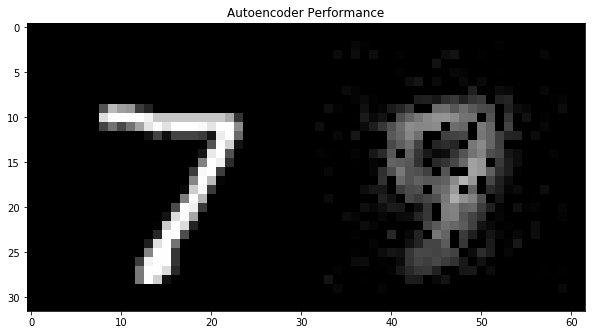

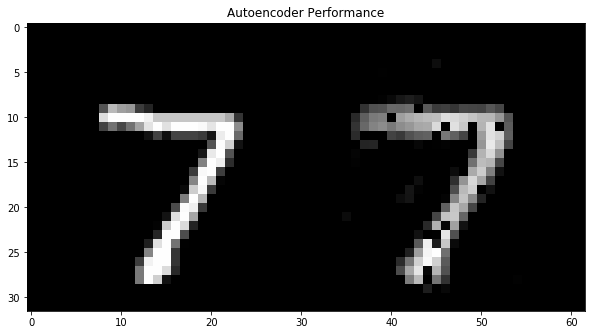

In [7]:
for i in range(iterations/10):
    imshow(torchvision.utils.make_grid(printImg[i]), 'Autoencoder Performance')

Encoder Weights Visualization:
=======================

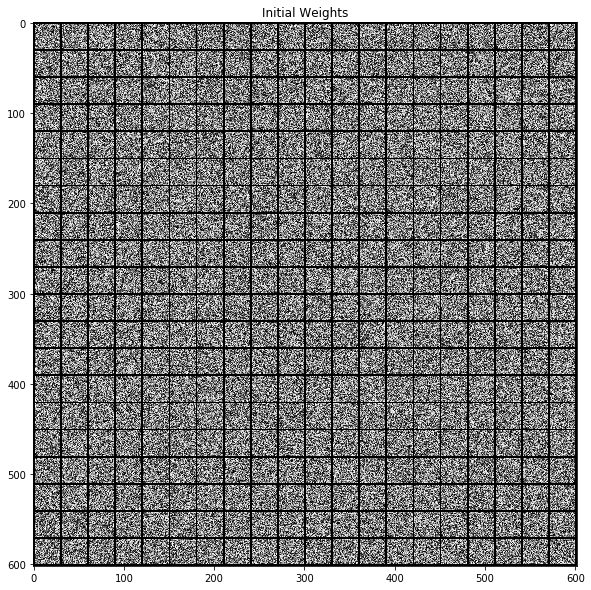

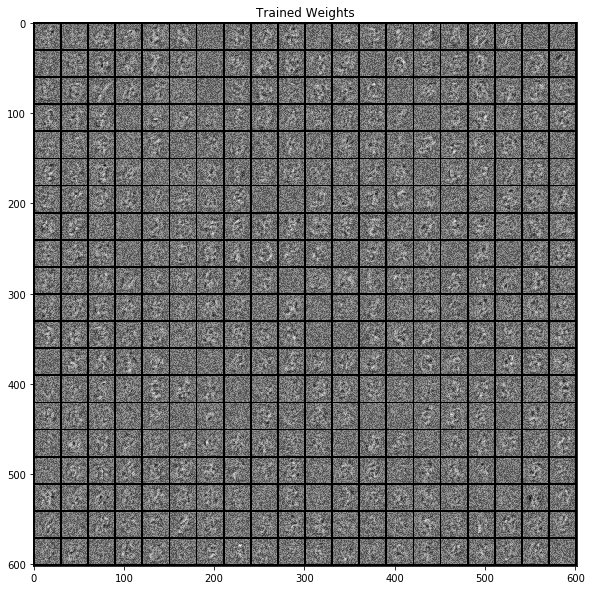

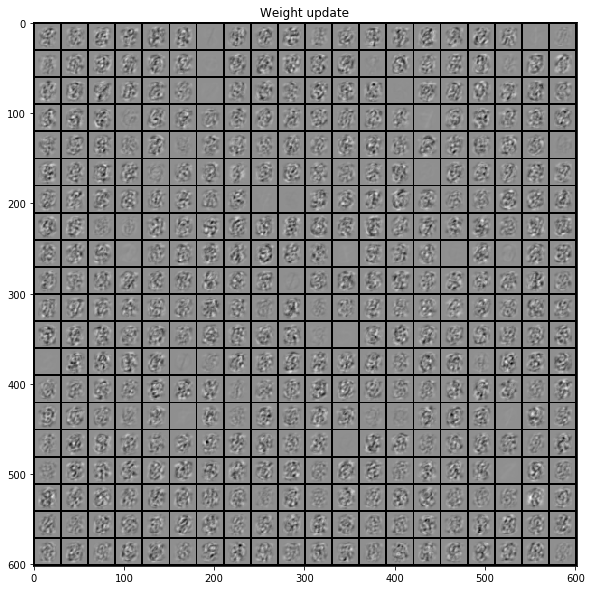

In [8]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)
d_weights = init_weights - trained_weights 

if use_gpu:
    init_weights = init_weights.view(400,1,28,28).cpu()
    trained_weights = trained_weights.view(400,1,28,28).cpu()
    d_weights = d_weights.view(400,1,28,28).cpu()
else:
    init_weights = init_weights.view(400,1,28,28)
    trained_weights = trained_weights.view(400,1,28,28)
    d_weights = d_weights.view(400,1,28,28)

imshow(torchvision.utils.make_grid(init_weights,nrow=20,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=20,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=20,normalize=True), 'Weight update')

Modifying the autoencoder for classification: 
================================

In [9]:
# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
# Adding linear layer for 10-class classification problem
net.add_module('classifier', nn.Sequential(nn.Linear(256, 10),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
# Copying initial weights  for visualization
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=400)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=256)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=10)
    (1): LogSoftmax()
  )
)


Train Classifier:
===========

In [10]:
iterations = 10
learning_rate = 0.1
criterion = nn.NLLLoss()

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), Variable(labels)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.data[0]
        correct = 0
        total = 0
    for data in testloader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), labels.cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), labels
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize),100 * correct /float(total)))
print('Finished Training')

/home/iteradmin/anaconda2/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


At Iteration : 1 / 10  ;  Train Error : 0.429643 ;Test Accuracy : 92.170000
At Iteration : 2 / 10  ;  Train Error : 0.213818 ;Test Accuracy : 95.100000
At Iteration : 3 / 10  ;  Train Error : 0.155297 ;Test Accuracy : 95.720000
At Iteration : 4 / 10  ;  Train Error : 0.122205 ;Test Accuracy : 96.400000
At Iteration : 5 / 10  ;  Train Error : 0.100192 ;Test Accuracy : 97.180000
At Iteration : 6 / 10  ;  Train Error : 0.084210 ;Test Accuracy : 97.240000
At Iteration : 7 / 10  ;  Train Error : 0.072508 ;Test Accuracy : 97.380000
At Iteration : 8 / 10  ;  Train Error : 0.062631 ;Test Accuracy : 97.610000
At Iteration : 9 / 10  ;  Train Error : 0.054970 ;Test Accuracy : 97.670000
At Iteration : 10 / 10  ;  Train Error : 0.048178 ;Test Accuracy : 97.650000
Finished Training


Encoder Weights Visualization:
=======================

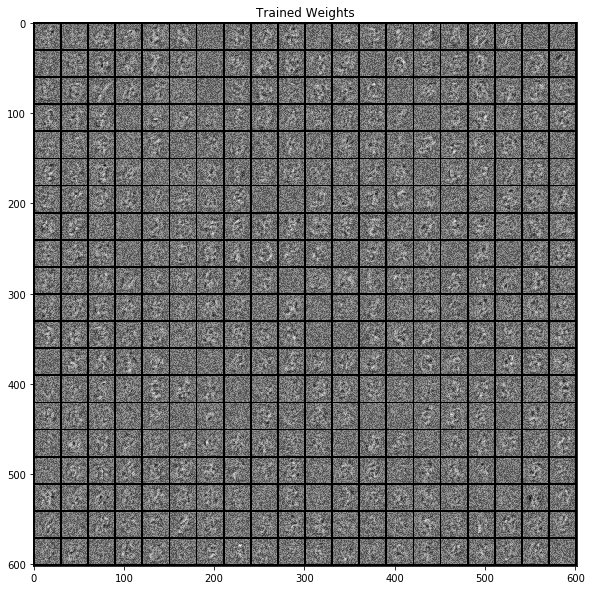

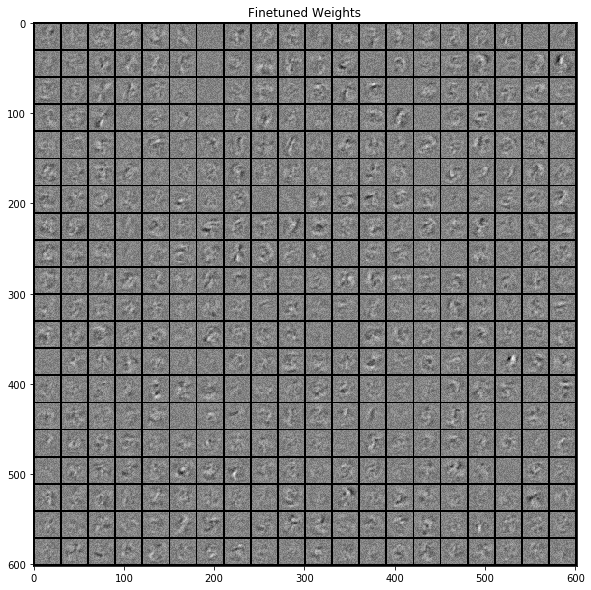

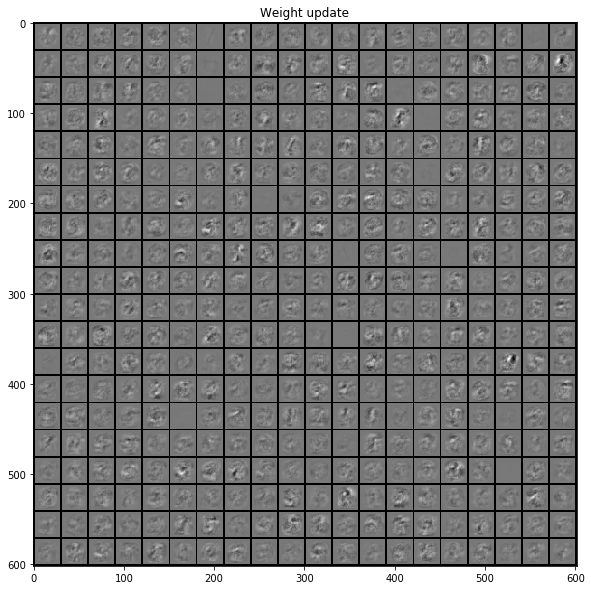

In [11]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)
d_weights = cll_weights-cll_weights_ft 

if use_gpu:
    cll_weights = cll_weights.view(400,1,28,28).cpu()
    cll_weights_ft = cll_weights_ft.view(400,1,28,28).cpu()
    d_weights = d_weights.view(400,1,28,28).cpu()
else:
    cll_weights = cll_weights.view(400,1,28,28)
    cll_weights_ft = cll_weights_ft.view(400,1,28,28)
    d_weights = d_weights.view(400,1,28,28)

imshow(torchvision.utils.make_grid(cll_weights,nrow=20,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(cll_weights_ft,nrow=20,normalize=True),'Finetuned Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=20,normalize=True), 'Weight update')

Performance of different Classes:
==================

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    if use_gpu:
        outputs = net(Variable(images.view(-1, 28*28).double().cuda()))
        _, predicted = torch.max(outputs.data.cpu(), 1)
    else:
        outputs = net(Variable(images.view(-1, 28*28).double()))
        _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(BatchSize):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of  zero : 98.979592 %
Accuracy of   one : 99.030837 %
Accuracy of   two : 98.158915 %
Accuracy of three : 98.910891 %
Accuracy of  four : 97.250509 %
Accuracy of  five : 95.403587 %
Accuracy of   six : 97.703549 %
Accuracy of seven : 97.081712 %
Accuracy of eight : 97.125257 %
Accuracy of  nine : 96.432111 %
